In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.linalg import lstsq
import scipy.optimize as opt
from tqdm.notebook import tqdm

sns.set(color_codes=True)
mpl.rcParams['figure.dpi'] = 120

In [119]:
name1 = 'Канал 1_600nm_0.03.csv'
name2 = 'Канал 2_600nm_0.03.csv'
df1 = pd.read_csv(name1, delimiter=';', encoding='ANSI')
df1.columns = ['мВ', 'мА']
df2 = pd.read_csv(name2, delimiter=';', encoding='ANSI')
df2.columns = ['мВ', 'мА']

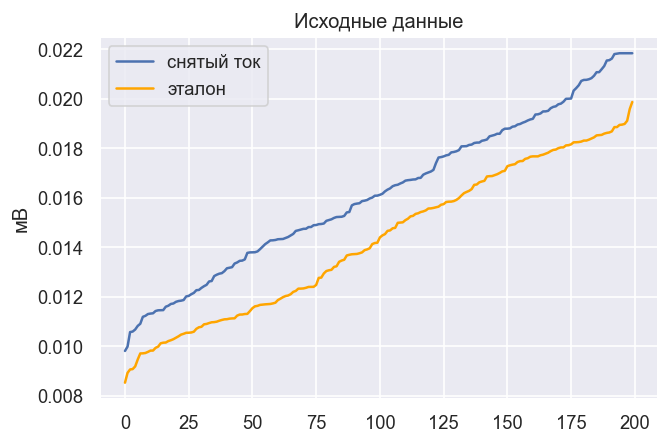

In [120]:
plt.title('Исходные данные')

plt.plot(df1['мВ'], label='снятый ток', color='b')
plt.plot(df2['мВ'], label='эталон', color='orange')
plt.legend()
plt.ylabel('мВ')
plt.show()

In [121]:
eps = 1e-4

In [122]:
df1['infV'] = df1['мВ'] - eps
df1['supV'] = df1['мВ'] + eps

df2['infV'] = df2['мВ'] - eps
df2['supV'] = df2['мВ'] + eps

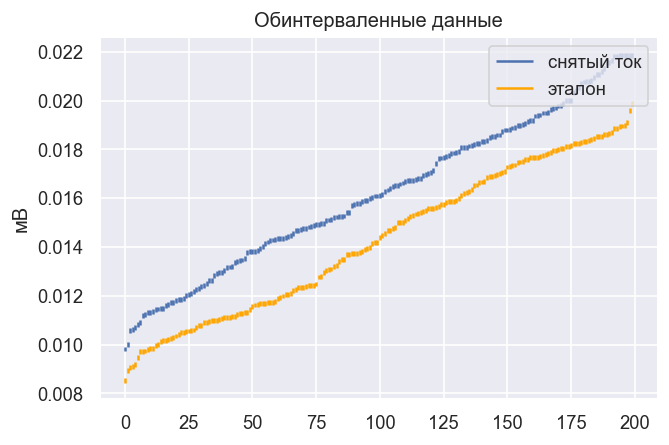

In [123]:
plt.title('Обинтерваленные данные')

plt.vlines(np.arange(len(df1)), df1['infV'], df1['supV'], label='снятый ток', colors='b')
plt.vlines(np.arange(len(df2)), df2['infV'], df2['supV'], label='эталон', colors='orange')

plt.legend()
plt.ylabel('мВ')

plt.show()

In [124]:
borders = [0, 20, 180, 200]

In [125]:
x = np.arange(len(df1))
A = np.vstack([x, np.ones(len(x))]).T

In [126]:
sol1 = []
for l, r in zip(borders[:-1], borders[1:]):
    sol1.append(lstsq(A[l:r], df1['мВ'].iloc[l:r])[0])
    
sol2 = []
for l, r in zip(borders[:-1], borders[1:]):
    sol2.append(lstsq(A[l:r], df2['мВ'].iloc[l:r])[0])

C:\Users\Daniil\AppData\Local\Temp\ipykernel_13072\1809305340.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol1.append(lstsq(A[l:r], df1['мВ'].iloc[l:r])[0])
C:\Users\Daniil\AppData\Local\Temp\ipykernel_13072\1809305340.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol2.append(lstsq(A[l:r], df2['мВ'].iloc[l:r])[0])


In [127]:
mnk1 = []
for sol, l, r in zip(sol1, borders[:-1], borders[1:]):
    mnk1.extend(sol[0] * x[l:r] + sol[1])
    
mnk2 = []
for sol, l, r in zip(sol2, borders[:-1], borders[1:]):
    mnk2.extend(sol[0] * x[l:r] + sol[1])

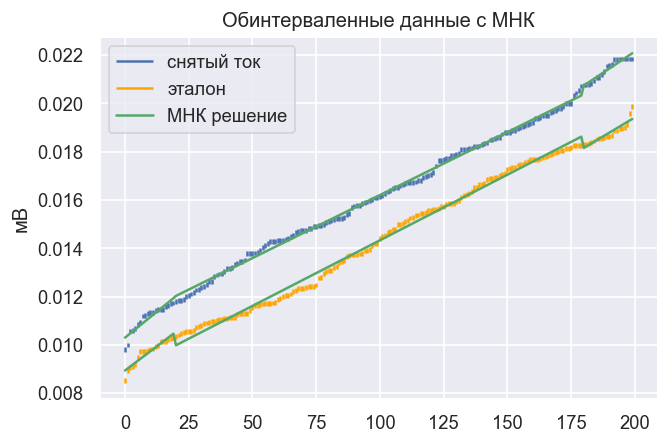

In [128]:
plt.title('Обинтерваленные данные с МНК')

plt.vlines(np.arange(len(df1)), df1['infV'], df1['supV'], label='снятый ток', colors='b')
plt.plot(x, mnk1, c='g')

plt.vlines(np.arange(len(df2)), df2['infV'], df2['supV'], label='эталон', colors='orange')
plt.plot(x, mnk2, c='g' ,label='МНК решение')

plt.ylabel('мВ')
plt.legend()

plt.show()

In [129]:
w1 = []
for pred, tg in zip(mnk1, df1['мВ']):
    w1.append(max(abs(pred-tg) / eps, 1))
w1 = np.array(w1)

w2 = []
for pred, tg in zip(mnk2, df2['мВ']):
    w2.append(max(abs(pred-tg) / eps, 1))
w2 = np.array(w2)

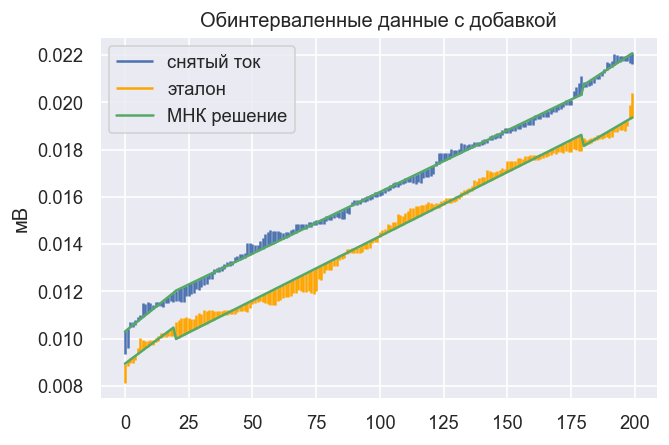

In [130]:
plt.title('Обинтерваленные данные с добавкой')

plt.vlines(x, df1['мВ']-[i*eps for i in w1], df1['мВ']+[i*eps for i in w1], label='снятый ток', colors='b')
plt.plot(x, mnk1, c='g')

plt.vlines(x, df2['мВ']-[i*eps for i in w2], df2['мВ']+[i*eps for i in w2], label='эталон', colors='orange')
plt.plot(x, mnk2, c='g',label='МНК решение')

plt.ylabel('мВ')
plt.legend()

plt.show()

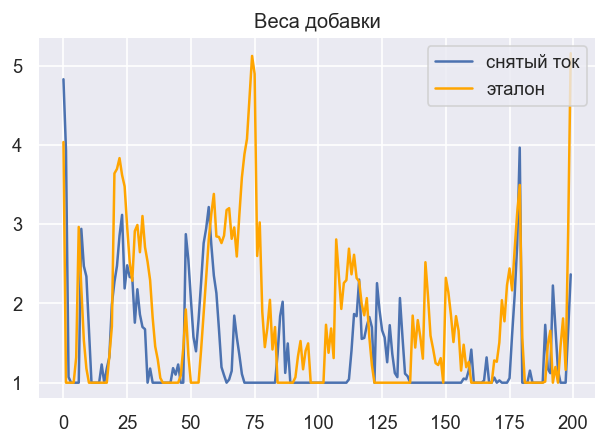

In [131]:
plt.title('Веса добавки')
plt.plot(w1, label='снятый ток', color='b')
plt.plot(w2, label='эталон', color='orange')
plt.legend()

plt.show()

In [132]:
new_rad1 = max(w1) * eps
new_rad2 = max(w2) * eps

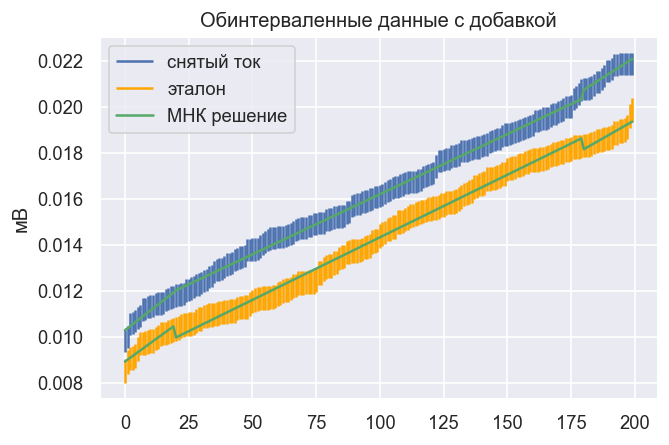

In [133]:
plt.title('Обинтерваленные данные с добавкой')

plt.vlines(x, df1['мВ']-new_rad1, df1['мВ']+new_rad1, label='снятый ток', colors='b')
plt.plot(x, mnk1, c='g')

plt.vlines(x, df2['мВ']-new_rad2, df2['мВ']+new_rad2, label='эталон', colors='orange')
plt.plot(x, mnk2, c='g',label='МНК решение')

plt.ylabel('мВ')
plt.legend()

plt.show()

In [134]:
def get_info(data, rad, x):
    data = data[borders[1]: borders[2]]
    x0 = x[borders[1]]
    x_new = np.arange(borders[2] - borders[1])
    x = x[borders[1]:borders[2]]
    bt = []
    bt_up = []
    bt_down = []
    for b in tqdm(np.arange(data[0] - rad, data[0] + rad, 1e-5)):
        for i in range(1, len(data)):
            k = (data[i] - rad - b) / i
            y = b + k * x_new
            if ((data - rad) <= y).all() and ((data + rad) >= y).all():
                bt.append([b-k*x0, k])
                bt_down.append([b-k*x0, k])

            k = (data[i] + rad - b) / i
            y = b + k * x_new
            if ((data - rad) <= y).all() and ((data + rad) >= y).all():
                bt.append([b-k*x0, k])
                bt_up.append([b-k*x0, k])
    print('hi')
    print(bt_down)
    print('hi')
    
    bt = np.array(bt)
    
    bt_down.sort()
    bt_up.sort()
    
    # btdf = pd.DataFrame(bt).groupby(0).agg(list).reset_index()
    print('hi')
    print(bt_down)
    print('hi')
    if bt_down != []:
        b0 = list(np.array(bt_down)[:, 0]) + list(np.array(bt_up)[:, 0][::-1])
    #b1 = np.array(btdf[1].tolist())
        b1 = list(np.array(bt_down)[:, 1]) + list(np.array(bt_up)[:, 1][::-1])
    
        x_ptp = bt[:, 0].max() - bt[:, 0].min()
        y_ptp = bt[:, 1].max() - bt[:, 1].min()
    
        plt.title('Информационное множество')
        plt.xlim(bt[:, 0].min() - x_ptp * 0.1, bt[:, 0].max() + x_ptp * 0.1)
        plt.ylim(bt[:, 1].min() - y_ptp * 0.1, bt[:, 1].max() + y_ptp * 0.1)
        axes = plt.gca()

        axes.add_patch(mpl.patches.Polygon(np.array([b0, b1]).T, color='g'))

        axes.add_patch(mpl.patches.Polygon(
            [(bt[:, 0].min(), bt[:, 1].min()),
             (bt[:, 0].min(), bt[:, 1].max()),
             (bt[:, 0].max(), bt[:, 1].max()),
             (bt[:, 0].max(), bt[:, 1].min())], 
            color='r', 
            fill=False
        ))

        plt.xlabel('\u03B20')
        plt.ylabel('\u03B21')
        plt.show()
    
    bbox = []
    for i in x:
        bbox.append([row[0] + i * row[1] for row in bt])

    bbox = np.array(bbox)
    
    plt.title('Диаграмма рассеяния и коридор совместности')
    plt.vlines(x, data-rad, data+rad, label='снятый ток', colors='b')

    axes = plt.gca()

    axes.add_patch(mpl.patches.Polygon(np.array([list(x) + list(x[::-1]), list(bbox.max(axis=1)) + list(bbox.min(axis=1)[::-1])]).T,
                                              color='g',
                                              alpha=0.5,
                                              zorder=3))
    
    return bt

  0%|          | 0/97 [00:00<?, ?it/s]

hi
[[0.010576364285714256, 5.664285714285772e-05], [0.010593507142857112, 5.628571428571488e-05], [0.010610302509652482, 5.5945945945946384e-05], [0.010625707915057885, 5.567567567567613e-05], [0.01064111332046329, 5.540540540540587e-05], [0.010656518725868695, 5.5135135135135605e-05], [0.0106719241312741, 5.486486486486535e-05], [0.010687329536679505, 5.459459459459509e-05], [0.01070273494208491, 5.432432432432483e-05], [0.010718140347490315, 5.405405405405457e-05], [0.010733545752895719, 5.378378378378431e-05], [0.010748951158301124, 5.3513513513514054e-05], [0.010764356563706529, 5.3243243243243796e-05], [0.010779761969111934, 5.297297297297353e-05], [0.010793498158131149, 5.2786163522012716e-05], [0.01080475601976637, 5.272327044025171e-05], [0.01081601388140159, 5.266037735849071e-05], [0.010827271743036809, 5.2597484276729705e-05], [0.010838529604672029, 5.25345911949687e-05], [0.010849787466307248, 5.24716981132077e-05], [0.010861045327942468, 5.2408805031446694e-05], [0.0108723

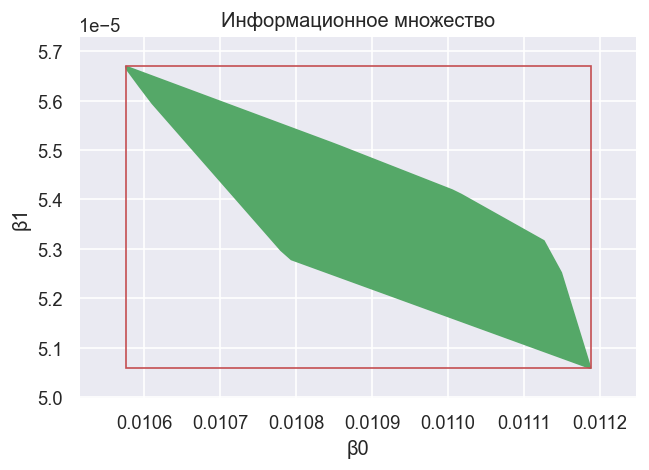

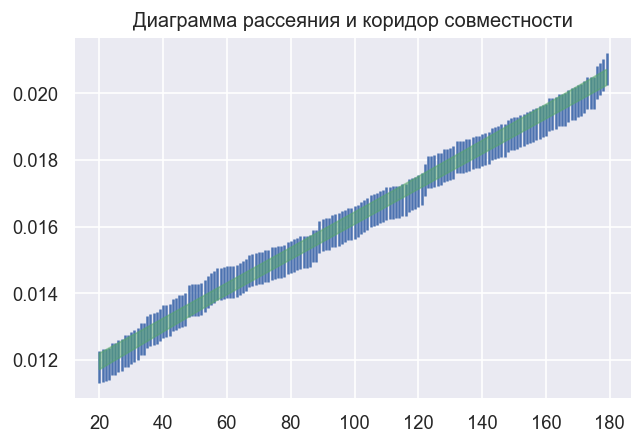

In [135]:
bt1 = get_info(df1['мВ'].tolist(), new_rad1, x)

  0%|          | 0/104 [00:00<?, ?it/s]

hi
[[0.008773414285714293, 5.400000000000023e-05], [0.008799971662763478, 5.317213114754098e-05], [0.008811611007025773, 5.309016393442623e-05], [0.008823250351288066, 5.300819672131148e-05], [0.00883488969555036, 5.292622950819673e-05], [0.008846529039812655, 5.284426229508198e-05], [0.00885816838407495, 5.276229508196723e-05], [0.008869807728337245, 5.2680327868852474e-05], [0.00888144707259954, 5.2598360655737724e-05], [0.008893086416861835, 5.2516393442622974e-05], [0.008904725761124128, 5.2434426229508224e-05], [0.008916365105386424, 5.2352459016393474e-05], [0.008928004449648717, 5.2270491803278724e-05], [0.008939643793911012, 5.2188524590163974e-05], [0.008951283138173307, 5.2106557377049224e-05], [0.008962922482435602, 5.202459016393447e-05], [0.008974561826697897, 5.194262295081972e-05], [0.00898618351648352, 5.1861538461538524e-05], [0.008997721978021981, 5.1784615384615455e-05], [0.009009260439560442, 5.170769230769238e-05], [0.009020798901098904, 5.1630769230769304e-05], [0

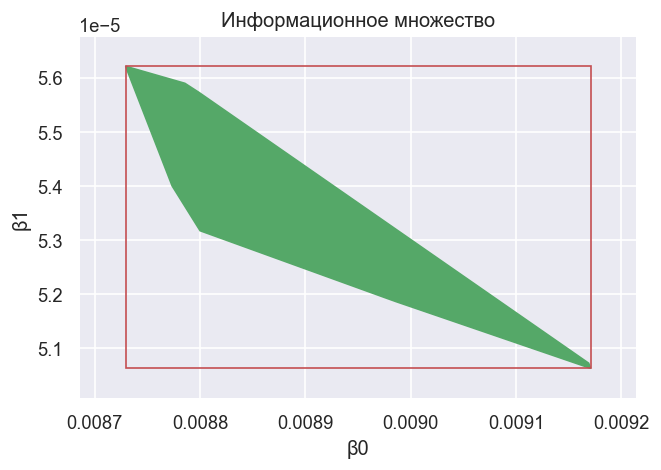

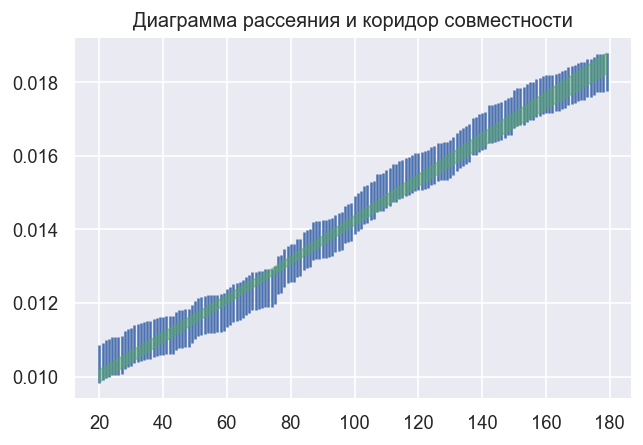

In [136]:
bt2 = get_info(df2['мВ'].tolist(), new_rad2, x)

In [137]:
def plot_predict(data, bt, x, borders):
    bbox = []
    x_osn = x[borders[1]: borders[2]]
    for i in x_osn:
        bbox.append([row[0] + i * row[1] for row in bt])

    bbox = np.array(bbox)
    
    d_max_otr = bbox.max(axis=1)[1] - bbox.max(axis=1)[0]
    d_max_pos = bbox.max(axis=1)[-1] - bbox.max(axis=1)[-2]
    d_min_otr = bbox.min(axis=1)[1] - bbox.min(axis=1)[0]
    d_min_pos = bbox.min(axis=1)[-1] - bbox.min(axis=1)[-2]

    x_otr = []
    y_otr = []
    for i, j in enumerate(np.arange(borders[1]-1, borders[0]-1, -1)):
        x_otr.append(j)
        y_otr.append(bbox.max(axis=1)[0] - d_max_otr*(i+1))

    for i, j in enumerate(np.arange(borders[0], borders[1])):
        x_otr.append(j)
        y_otr.append(bbox.min(axis=1)[0] - d_min_otr*(borders[1]-i))

    x_pos = []
    y_pos = []
    for i, j in enumerate(np.arange(borders[2], borders[3])):
        x_pos.append(j)
        y_pos.append(bbox.max(axis=1)[-1] + d_max_pos*(i+1))
    lag = borders[3] - borders[2]
    for i, j in enumerate(np.arange(borders[3]-1, borders[2]-1, -1)):
        x_pos.append(j)
        y_pos.append(bbox.min(axis=1)[-1] + d_min_pos*(lag-i))
        
    plt.title('Диаграмма рассеяния и коридор совместности внутри и вне интервала имеющихся данных')
    plt.vlines(x, data[0], data[1], label='снятый ток', colors='b')

    axes = plt.gca()

    axes.add_patch(mpl.patches.Polygon(np.array([list(x_osn) + list(x_osn[::-1]), list(bbox.max(axis=1)) + list(bbox.min(axis=1)[::-1])]).T,
                                              color='g',
                                              alpha=0.6,
                                              zorder=3))

    axes.add_patch(mpl.patches.Polygon(np.array([x_otr, y_otr]).T,
                                              color='r',
                                              alpha=0.6,
                                              zorder=3))

    axes.add_patch(mpl.patches.Polygon(np.array([x_pos, y_pos]).T,
                                              color='r',
                                              alpha=0.6,
                                              zorder=3))
    
    plt.show()
    
    otr = [y_otr[len(y_otr)//2:], y_otr[:len(y_otr)//2][::-1]]
    pos = [y_pos[len(y_pos)//2:][::-1], y_pos[:len(y_pos)//2]]
    osn = [list(bbox.min(axis=1)), list(bbox.max(axis=1))]
    
    return otr, osn, pos

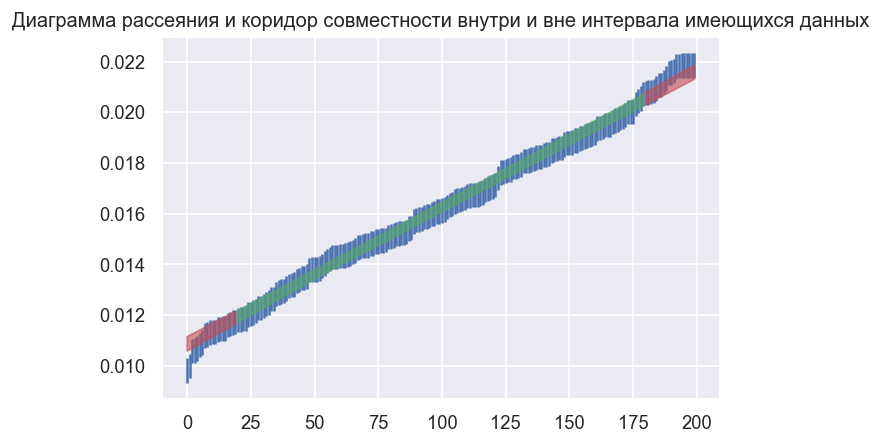

In [138]:
plot_predict([(df1['мВ'] - new_rad1).tolist(), (df1['мВ'] + new_rad1).tolist()], bt1, x, borders);

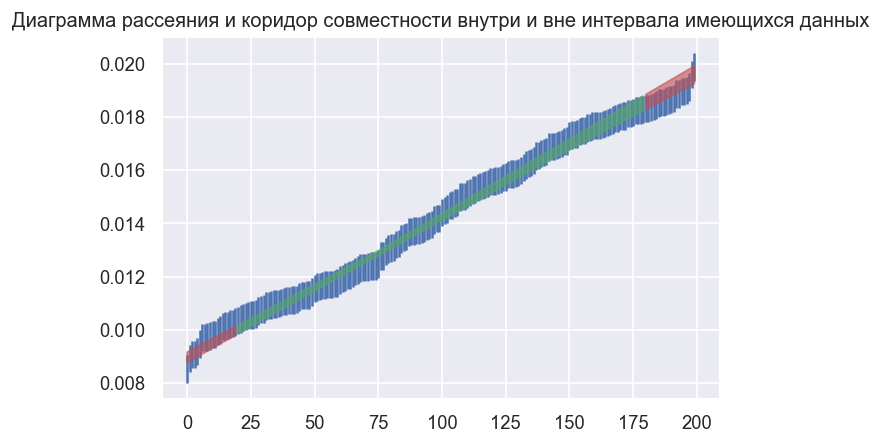

In [139]:
plot_predict([(df2['мВ'] - new_rad2).tolist(), (df2['мВ'] + new_rad2).tolist()], bt2, x, borders);

In [140]:
h_mnk1 = mnk1 - sol1[1][1]
h_mnk2 = mnk2 - sol2[1][1]

In [141]:
df1['infI'] = df1['мВ'] - new_rad1 - h_mnk1
df1['supI'] = df1['мВ'] + new_rad1 - h_mnk1

df2['infI'] = df2['мВ'] - new_rad2 - h_mnk2
df2['supI'] = df2['мВ'] + new_rad2 - h_mnk2

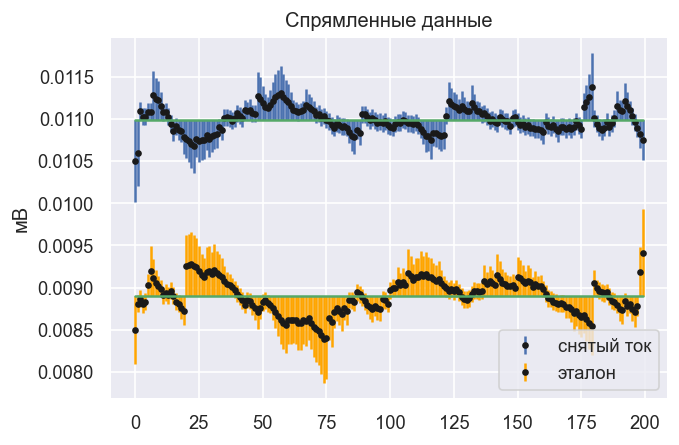

In [142]:
plt.title('Спрямленные данные')

plt.errorbar(x, df1["мВ"] - h_mnk1, yerr=[i*eps for i in w1], c='k', ecolor='b', marker='o', ms=3, linestyle='none', label='снятый ток')
plt.errorbar(x, df2["мВ"] - h_mnk2, yerr=[i*eps for i in w2], c='k', ecolor='orange', marker='o', ms=3, linestyle='none', label='эталон')

plt.plot(x, [sol1[1][1] for _ in x], c='g', zorder=3)

plt.plot(x, [sol2[1][1] for _ in x], c='g', zorder=3)

plt.ylabel('мВ')
plt.legend()

plt.show()

  0%|          | 0/97 [00:00<?, ?it/s]

hi
[[0.010576364285714257, 4.445524727528969e-06], [0.010593507142857114, 4.088381870386127e-06], [0.010610302509652482, 3.74861353061766e-06], [0.010625707915057887, 3.478343260347401e-06], [0.010641113320463292, 3.2080729900771413e-06], [0.010656518725868697, 2.937802719806882e-06], [0.0106719241312741, 2.667532449536623e-06], [0.010687329536679505, 2.3972621792663635e-06], [0.01070273494208491, 2.1269919089961044e-06], [0.010718140347490315, 1.856721638725845e-06], [0.01073354575289572, 1.586451368455586e-06], [0.010748951158301125, 1.3161810981853266e-06], [0.01076435656370653, 1.0459108279150673e-06], [0.010779761969111935, 7.75640557644808e-07], [0.01079349815813115, 5.888311066840016e-07], [0.01080475601976637, 5.259380249229979e-07], [0.01081601388140159, 4.6304494316199413e-07], [0.010827271743036809, 4.0015186140099045e-07], [0.010838529604672029, 3.372587796399867e-07], [0.01084978746630725, 2.7436569787898297e-07], [0.010861045327942468, 2.1147261611797924e-07], [0.01087230

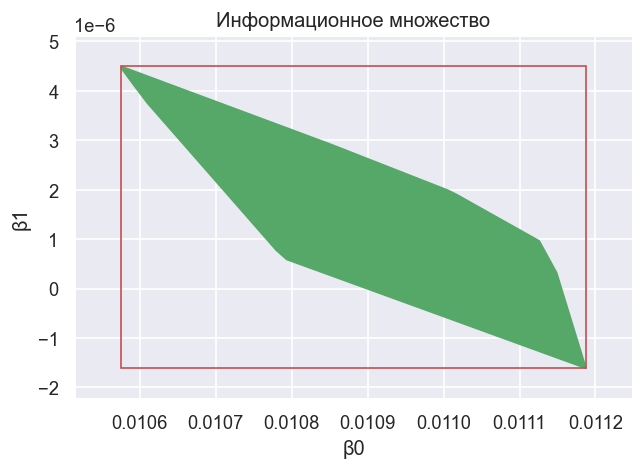

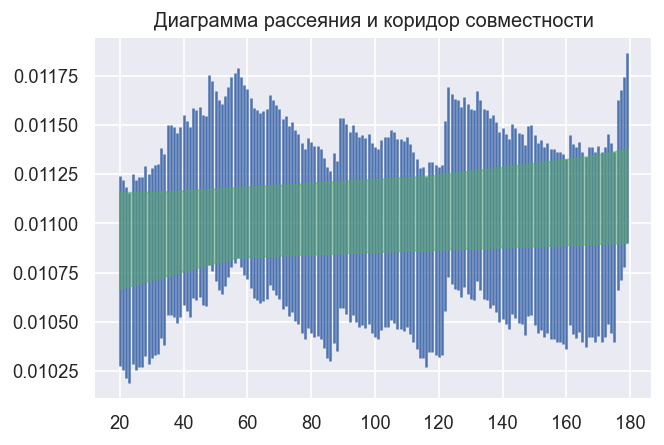

In [143]:
bt11 = get_info((df1['мВ']- h_mnk1).tolist(), new_rad1, x);

  0%|          | 0/104 [00:00<?, ?it/s]

hi
[[0.008773414285714284, -3.3599554670037807e-07], [0.008799971662763476, -1.163864399160009e-06], [0.008811611007025771, -1.2458316122747598e-06], [0.008823250351288066, -1.3277988253895107e-06], [0.00883488969555036, -1.4097660385042615e-06], [0.008846529039812655, -1.4917332516190122e-06], [0.008858168384074949, -1.5737004647337629e-06], [0.008869807728337243, -1.6556676778485136e-06], [0.008881447072599538, -1.7376348909632643e-06], [0.008893086416861833, -1.8196021040780153e-06], [0.008904725761124128, -1.901569317192766e-06], [0.008916365105386423, -1.983536530307517e-06], [0.008928004449648717, -2.0655037434222676e-06], [0.008939643793911012, -2.1474709565370183e-06], [0.008951283138173307, -2.229438169651769e-06], [0.0089629224824356, -2.3114053827665198e-06], [0.008974561826697895, -2.3933725958812705e-06], [0.00898618351648352, -2.474457085162467e-06], [0.00899772197802198, -2.551380162085541e-06], [0.009009260439560442, -2.6283032390086146e-06], [0.009020798901098902, -2.7

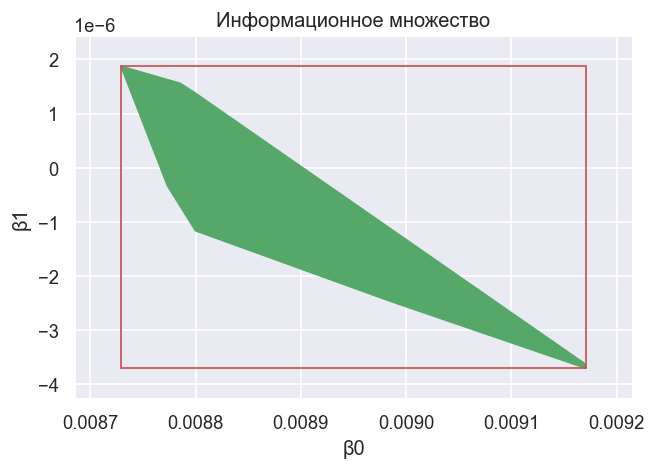

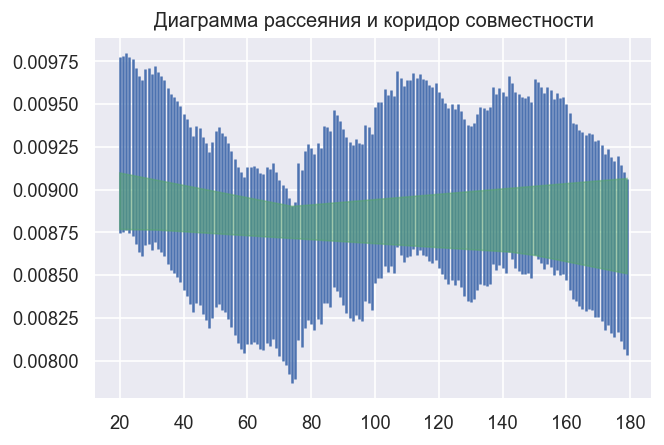

In [144]:
bt21 = get_info((df2['мВ']- h_mnk2).tolist(), new_rad2, x);

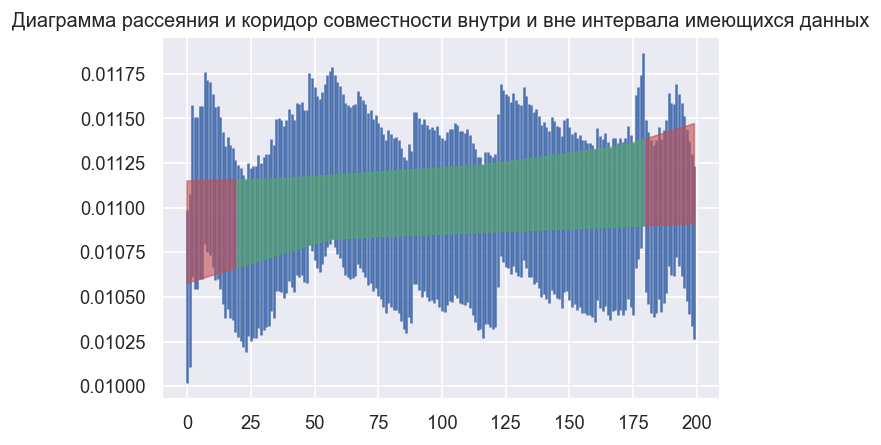

In [145]:
ost1 = plot_predict([(df1['мВ'] - new_rad1 - h_mnk1).tolist(), (df1['мВ'] + new_rad1 - h_mnk1).tolist()], bt11, x, borders)

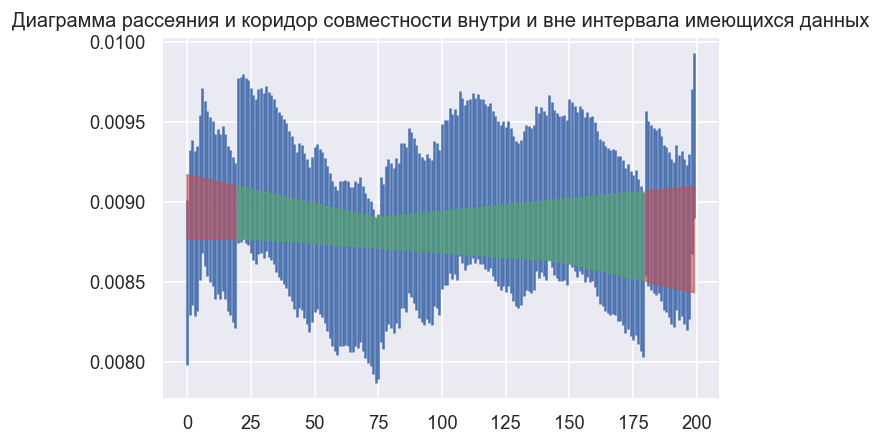

In [146]:
ost2 = plot_predict([(df2['мВ'] - new_rad2 - h_mnk2).tolist(), (df2['мВ'] + new_rad2 - h_mnk2).tolist()], bt21, x, borders)

In [147]:
ost1 = np.array([ost1[0][0] + ost1[1][0] + ost1[2][0], ost1[0][1] + ost1[1][1] + ost1[2][1]])
ost2 = np.array([ost2[0][0] + ost2[1][0] + ost2[2][0], ost2[0][1] + ost2[1][1] + ost2[2][1]])

In [148]:
r1 = ((df1['мВ'] - h_mnk1 - ost1.mean(axis=0)) / new_rad1).to_numpy()
r2 = ((df2['мВ'] - h_mnk2 - ost2.mean(axis=0)) / new_rad2).to_numpy()

In [149]:
l1 = (ost1[1] - ost1[0]) / 2 / new_rad1
l2 = (ost2[1] - ost2[0]) / 2 / new_rad2

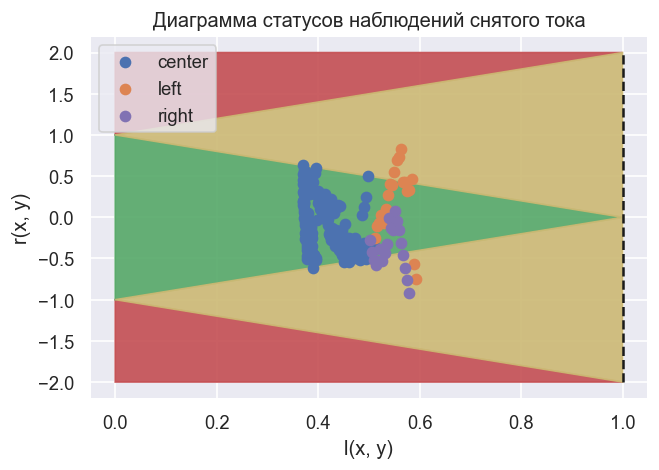

In [150]:
plt.title('Диаграмма статусов наблюдений снятого тока')
plt.scatter(l1[borders[1]: borders[2]], r1[borders[1]: borders[2]], zorder=3, label='center')
plt.scatter(l1[borders[0]: borders[1]], r1[borders[0]: borders[1]], zorder=3, label='left')
plt.scatter(l1[borders[2]: borders[3]], r1[borders[2]: borders[3]], zorder=3, label='right', c='m')
axes = plt.gca()

axes.add_patch(mpl.patches.Polygon(np.array([[0, 0, max(1, l1.max()+0.1)], [-2, -1, -2]]).T,
                                          color='r',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[0, 0, max(1, l1.max()+0.1)], [2, 1, 2]]).T,
                                          color='r',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[0, 1, 0], [-1, 0, 1]]).T,
                                          color='g',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[max(1, l1.max()+0.1), 0, 1, 0, max(1, l1.max()+0.1)], 
                                             [-2, -1, 0, 1, 2]]
                                           ).T,
                                          color='y',
                                          alpha=0.9))

plt.plot([1, 1], [-2, 2], c='k', linestyle='--')

plt.xlabel('l(x, y)')
plt.ylabel('r(x, y)')
plt.legend()
plt.show()

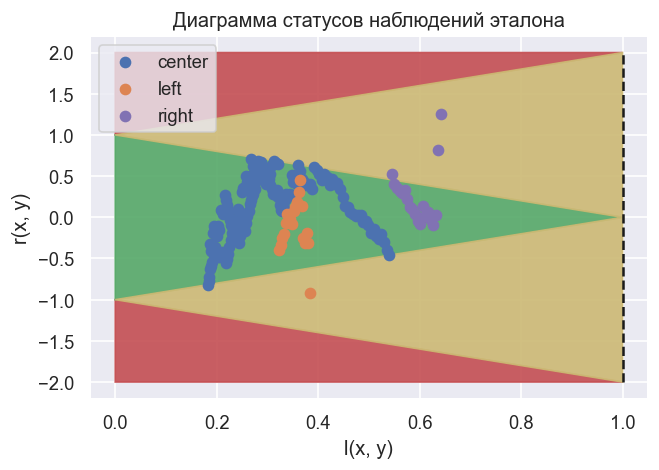

In [151]:
plt.title('Диаграмма статусов наблюдений эталона')
plt.scatter(l2[borders[1]: borders[2]], r2[borders[1]: borders[2]], zorder=3, label='center')
plt.scatter(l2[borders[0]: borders[1]], r2[borders[0]: borders[1]], zorder=3, label='left')
plt.scatter(l2[borders[2]: borders[3]], r2[borders[2]: borders[3]], zorder=3, label='right', c='m')
axes = plt.gca()

axes.add_patch(mpl.patches.Polygon(np.array([[0, 0, max(1, l2.max()+0.1)], [-2, -1, -2]]).T,
                                          color='r',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[0, 0, max(1, l2.max()+0.1)], [2, 1, 2]]).T,
                                          color='r',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[0, 1, 0], [-1, 0, 1]]).T,
                                          color='g',
                                          alpha=0.9))

axes.add_patch(mpl.patches.Polygon(np.array([[max(1, l2.max()+0.1), 0, 1, 0, max(1, l2.max()+0.1)], 
                                             [-2, -1, 0, 1, 2]]
                                           ).T,
                                          color='y',
                                          alpha=0.9))

plt.plot([1, 1], [-2, 2], c='k', linestyle='--')

plt.xlabel('l(x, y)')
plt.ylabel('r(x, y)')
plt.legend()
plt.show()

In [152]:
def JK(sup, inf):
    nom = min(sup) - max(inf)
    denom = max(sup) - min(inf)
    
    return nom / denom

In [153]:
def interval_union(sup, inf):

    merged = np.array([False] * len(sup))
    ch = 0
    while True:

        sup = sup[~merged]
        inf = inf[~merged]
        merged = np.array([False] * len(sup))

        for i in range(len(sup)):
            for j in range(len(sup)):
                if i == j:
                    break
                if (sup[i] >= sup[j]) and (inf[i] <= sup[j]):
                    inf[i] = min(inf[i], inf[j])
                    ch+=1
                    merged[j] = True
                if (sup[i] >= inf[j]) and (inf[i] <= inf[j]):
                    sup[i] = max(sup[i], sup[j])
                    ch+=1
                    merged[j] = True
        if ch == 0:
            break
        else:
            ch=0
            
    return sup, inf


def get_moda(sup, inf):
    r = []
    deletes = []
    for i in sup:
        dl = (inf >= i) | (sup < i)
        deletes.append(dl)
        r.append(dl.sum())

    r = np.array(r)
    f = r == min(r)

    ids = np.where(f)[0]

    inf_moda = []
    for i in ids:
        inf_moda.append(max(inf[(~deletes[i]) & (inf<sup[i])]))

    sup_moda, inf_moda = interval_union(sup[ids], np.array(inf_moda))
    
    width = (sup_moda - inf_moda).sum()

    print('\u222A'.join(['[{}, {}]'.format(np.round(down, 6), np.round(up, 6)) for down, up in zip(inf_moda, sup_moda)]))
    print('Ширина: {}'.format(np.round(width, 6)))
    print(f'Частота: {len(sup) - min(r)}')
    
    return width

0.0001


  0%|          | 0/20 [00:00<?, ?it/s]

hi
[]
hi
hi
[]
hi


ValueError: zero-size array to reduction operation maximum which has no identity

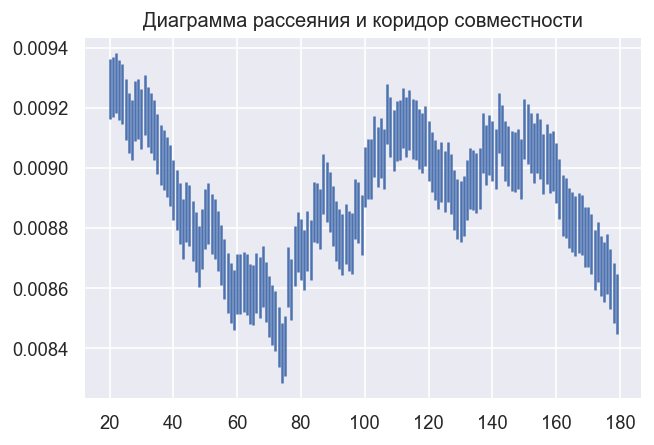

In [154]:
ws = []
jks = []
rads = np.arange(1e-4, 1e-3, 2e-4)
for rad in rads:
    print(rad)
    
    
    
    bt = get_info((df2['мВ']- h_mnk2).tolist(), rad, x);
    
    ost = plot_predict([(df2['мВ'] - rad - h_mnk2).tolist(), (df2['мВ'] + rad - h_mnk2).tolist()], bt, x, borders)
    ost = np.array([ost[0][0] + ost[1][0] + ost[2][0], ost[0][1] + ost[1][1] + ost[2][1]])
    
    r = ((df2['мВ'] - h_mnk2 - ost.mean(axis=0)) / rad).to_numpy()
    l = (ost[1] - ost[0]) / 2 / rad
    
    
    plt.title(f'Диаграмма статусов наблюдений эталона,  радиус={rad:.4f}')
    plt.scatter(l[borders[1]: borders[2]], r[borders[1]: borders[2]], zorder=3, label='center')
    plt.scatter(l[borders[0]: borders[1]], r[borders[0]: borders[1]], zorder=3, label='left')
    plt.scatter(l[borders[2]: borders[3]], r[borders[2]: borders[3]], zorder=3, label='right', c='m')
    axes = plt.gca()

    axes.add_patch(mpl.patches.Polygon(np.array([[0, 0, max(1, l.max()+0.1)], [-2, -1, -2]]).T,
                                              color='r',
                                              alpha=0.9))

    axes.add_patch(mpl.patches.Polygon(np.array([[0, 0, max(1, l.max()+0.1)], [2, 1, 2]]).T,
                                              color='r',
                                              alpha=0.9))

    axes.add_patch(mpl.patches.Polygon(np.array([[0, 1, 0], [-1, 0, 1]]).T,
                                              color='g',
                                              alpha=0.9))

    axes.add_patch(mpl.patches.Polygon(np.array([[max(1, l.max()+0.1), 0, 1, 0, max(1, l.max()+0.1)], 
                                                 [-2, -1, 0, 1, 2]]
                                               ).T,
                                              color='y',
                                              alpha=0.9))

    plt.plot([1, 1], [-2, 2], c='k', linestyle='--')

    plt.xlabel('l(x, y)')
    plt.ylabel('r(x, y)')
    plt.legend()
    plt.show()
    
    jk = JK((df2['мВ'] + rad - h_mnk2).to_numpy(), (df2['мВ'] - rad - h_mnk2).to_numpy())
    w = get_moda((df2['мВ'] + rad - h_mnk2).to_numpy(), (df2['мВ'] - rad - h_mnk2).to_numpy())
    
    jks.append(jk)
    ws.append(w)
    
    print('Мера Жаккара: ' + "{:.4f}".format(jk))
    
    
    print(f'Зеленая зона: {(np.abs(r) <= 1-l).sum()}')
    print()

In [90]:
sup = np.array([4, 9, 4.5, 9])
inf = np.array([1, 5, 1.5, 6])

In [91]:
get_moda(sup, inf);

[1.5, 4.0]∪[6.0, 9.0]
Ширина: 5.5
Частота: 2


ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

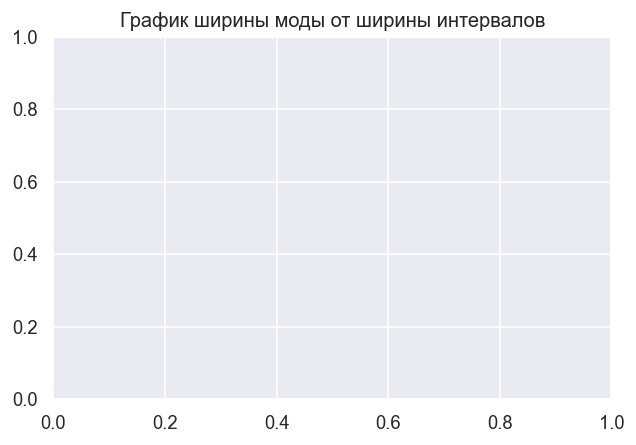

In [92]:
plt.title('График ширины моды от ширины интервалов')
plt.plot(rads*2, ws)
plt.xlabel('Ширина интервалов')
plt.ylabel('Ширина моды')
plt.show()

In [ ]:
plt.title('График к-та Жаккара от ширины интервалов')
plt.plot(rads*2, jks)
plt.xlabel('Ширина интервалов')
plt.ylabel('К-т Жаккара')
plt.show()